In [1]:
include("../src/ising2d.jl")
import CairoMakie as cm
import LsqFit as lsq
using JLD2
using ProgressMeter
import StatsBase as sb
import Distributions as dist
import MultivariateStats as mvs
import Clustering as cl

## generate data


In [2]:
N_Sample = 1_000
grid_sizes = [10, 32]
temps = collect(1.0:0.005:4.0)

grids = []
mags = []
sus = []
for L in grid_sizes
    grids_L = Array{Array{Int,1},1}(undef, length(temps) * N_Sample)
    mags_ = Array{Float64,1}(undef, length(temps))
    sus_ = Array{Float64,1}(undef, length(temps))
    @showprogress Threads.@threads for (i, T) in collect(enumerate(temps))
        lookup_table = create_lookup_table(T)
        grid = create_equilibrated_grid(grid_size=L, lookup_table=lookup_table, T=T, initial_up_prob=0.5)
        energies_, magnetisations_, grids_ = sample_grid(grid, lookup_table, T=T, N=N_Sample,N_Subsweep=100*L^2)
        for j in 1:N_Sample
            grids_L[(i-1)*N_Sample+j] = grids_[j]
        end

        mags_[i] = mean(abs.(magnetisations_))
        sus_[i] = std(abs.(magnetisations_))^2 / T
    end
    push!(grids, grids_L)
    push!(mags, mags_)
    push!(sus, sus_)
end

expanded_temps = repeat(temps, inner=N_Sample)
length(temps)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


601

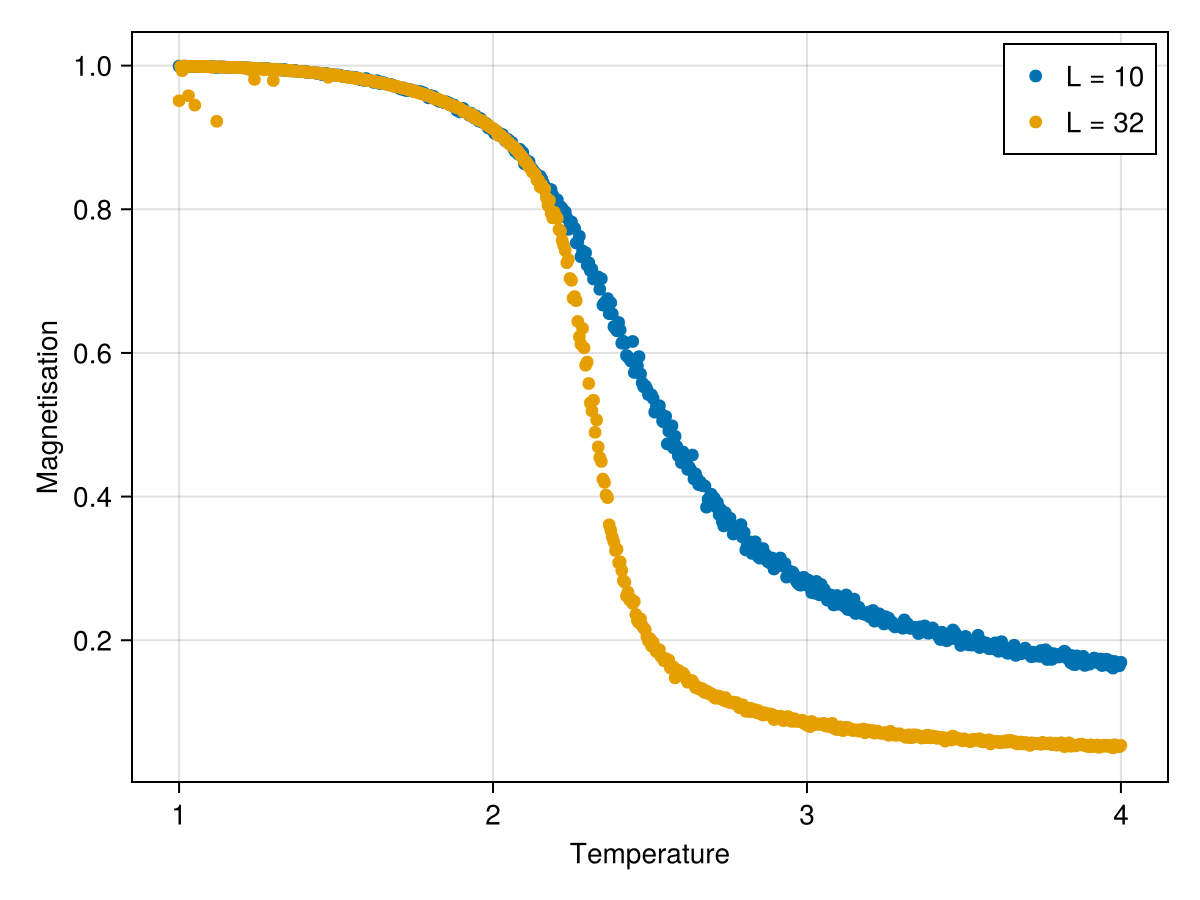

In [3]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1], xlabel="Temperature", ylabel="Magnetisation")
for (i, L) in collect(enumerate(grid_sizes))
    cm.plot!(ax, temps, mags[i], label="L = $L")
end

cm.axislegend(ax, position=:rt)

fig

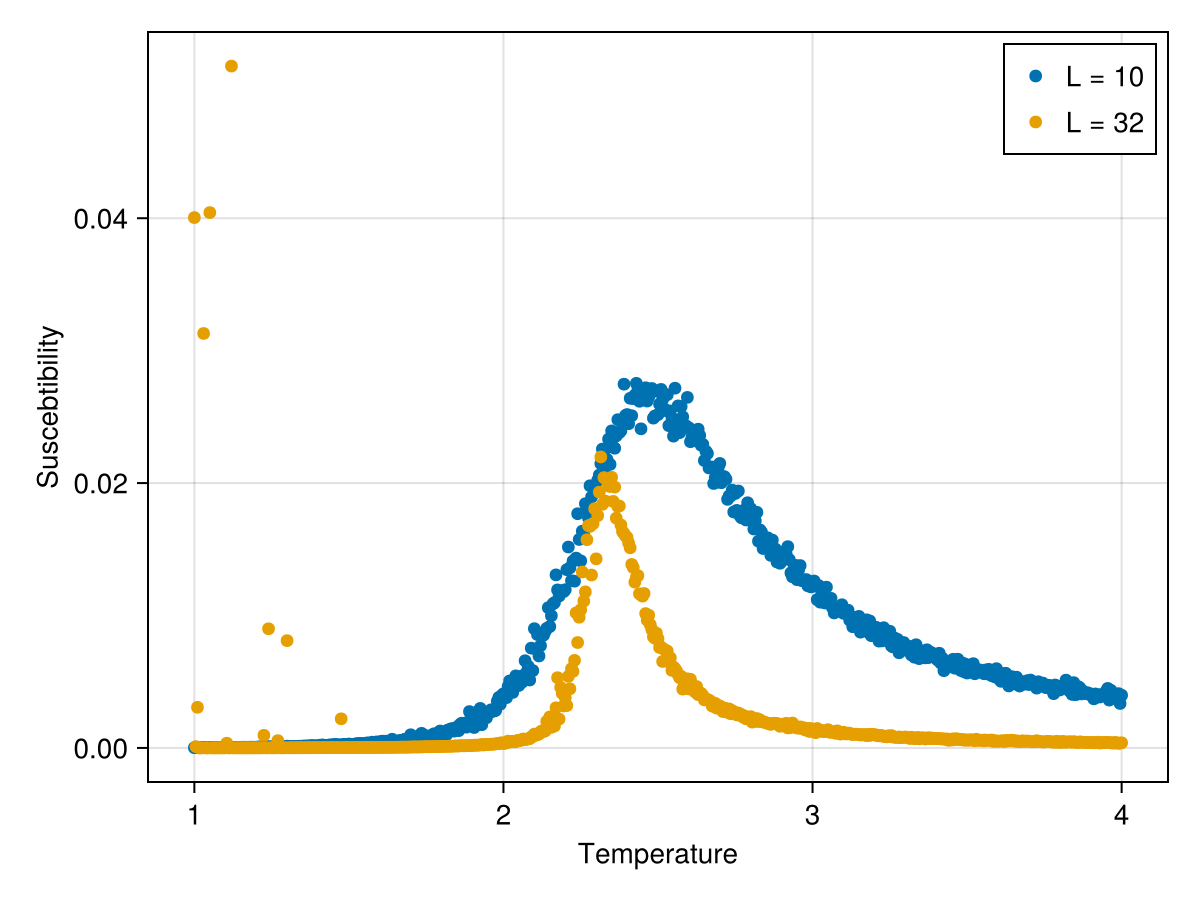

In [4]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1], xlabel="Temperature", ylabel="Suscebtibility")
for (i, L) in collect(enumerate(grid_sizes))
    cm.plot!(ax, temps, sus[i], label="L = $L")
end

cm.axislegend(ax, position=:rt)

fig

In [5]:
hcat(grids[1]...)

100×601000 Matrix{Int64}:
 -1  -1  -1  -1  -1  -1  -1  -1  -1  …   1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1     -1  -1  -1  -1  -1  -1  -1  -1  -1
 -1  -1  -1  -1  -1  -1  -1  -1  -1  …   1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1      1   1   1   1   1   1   1   1   1
  ⋮                   ⋮              ⋱                   ⋮              
 -1  -1  -1  -1  -1  -1  -1  -1  -1      1   1   1   1   1   1   1   1   1
 -1  -1  -1  -1  -1  -1  -1  -1  -1      1   1   1   1   1   1   1   1   1
 

## principal component analysis


In [6]:
M = []
for g in grids
    push!(M, sb.fit(mvs.PCA, hcat(g...), maxoutdim=2))
end

M[1]

PCA(indim = 100, outdim = 2, principalratio = 0.5034781960054472)

Pattern matrix (unstandardized loadings):
──────────────────────────
          PC1          PC2
──────────────────────────
1    0.711422   0.164344
2    0.694436   0.197392
3    0.67991    0.1473
4    0.696186   0.0740314
5    0.673848  -0.107701
6    0.686013  -0.120564
7    0.718986  -0.181036
8    0.705275  -0.214088
9    0.664269  -0.0943835
10   0.687894   0.0951971
11   0.681321   0.222894
12   0.702535   0.318122
13   0.680373   0.26424
14   0.695289   0.0938915
15   0.697137  -0.0737709
16   0.71459   -0.103988
17   0.706384  -0.194517
18   0.702716  -0.199824
19   0.661348  -0.0729444
20   0.69945    0.0385268
21   0.708775   0.265607
22   0.670093   0.358032
23   0.700591   0.187486
24   0.693538   0.028234
25   0.672665   0.0093461
26   0.683281  -0.0959969
27   0.684794  -0.17262
28   0.686217  -0.200463
29   0.695279  -0.0505589
30   0.707989  -0.0116861
31   0.691688   0.240459
32   0.692684   0.319438
33 

In [7]:
proj, appl = [], []
for i in 1:length(grid_sizes)
    push!(proj, mvs.projection(M[i]))
    push!(appl, hcat(grids[i]...)' * proj[i])
end

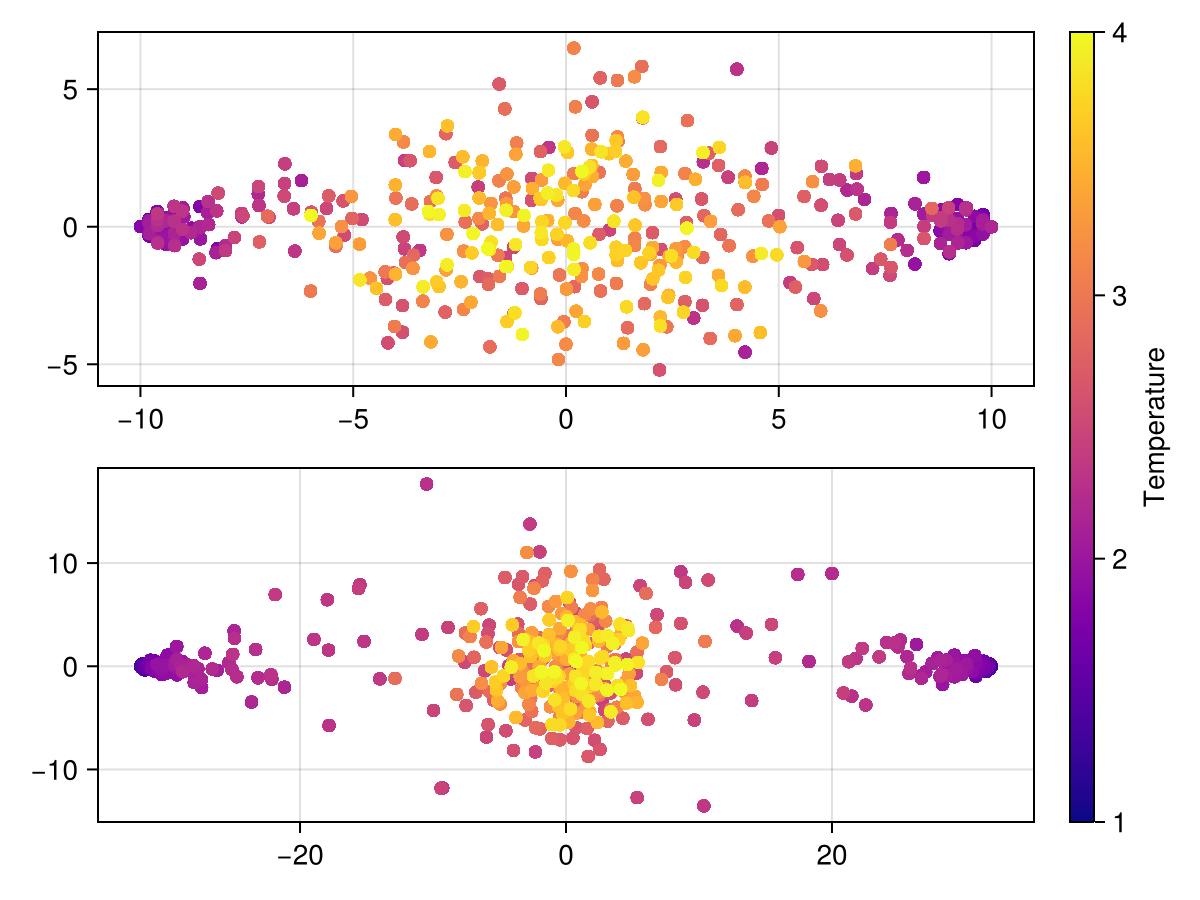

In [8]:
fig = cm.Figure()
cm.scatter(fig[1, 1], appl[1], color=expanded_temps, colormap=:plasma)
cm.scatter(fig[2, 1], appl[2], color=expanded_temps, colormap=:plasma)
# colorbar
cm.Colorbar(fig[:, 2], limits=(temps[begin], temps[end]), label="Temperature", colormap=:plasma)

fig

## K-means clustering


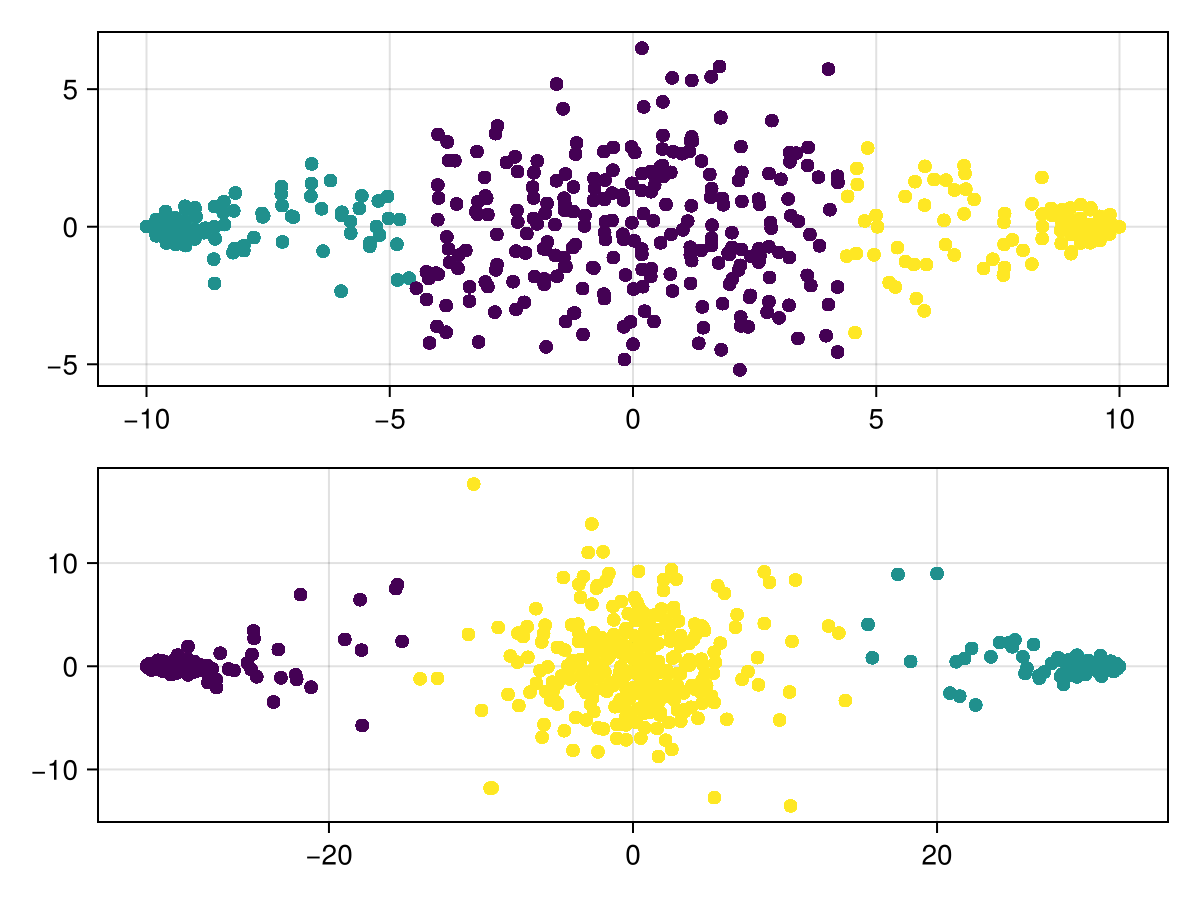

In [9]:
km1 = cl.kmeans(appl[1]', 3)
km2 = cl.kmeans(appl[2]', 3)

# plot clusters
fig = cm.Figure()
cm.scatter(fig[1, 1], appl[1], color=km1.assignments)
cm.scatter(fig[2, 1], appl[2], color=km2.assignments)
fig

In [10]:
a_mean = []
for i in 1:length(grid_sizes)
    am_ = []
    push!(am_, mean(reshape(abs.(appl[i][:, 1]), (length(temps), N_Sample)), dims=2)[:])
    push!(am_, mean(reshape(abs.(appl[i][:, 2]), (length(temps), N_Sample)), dims=2)[:])
    push!(a_mean, am_)
end

In [11]:
# normalize array to be from 0 to 1
normalize(x) = (x .- minimum(x)) ./ (maximum(x) .- minimum(x))

normalize (generic function with 1 method)

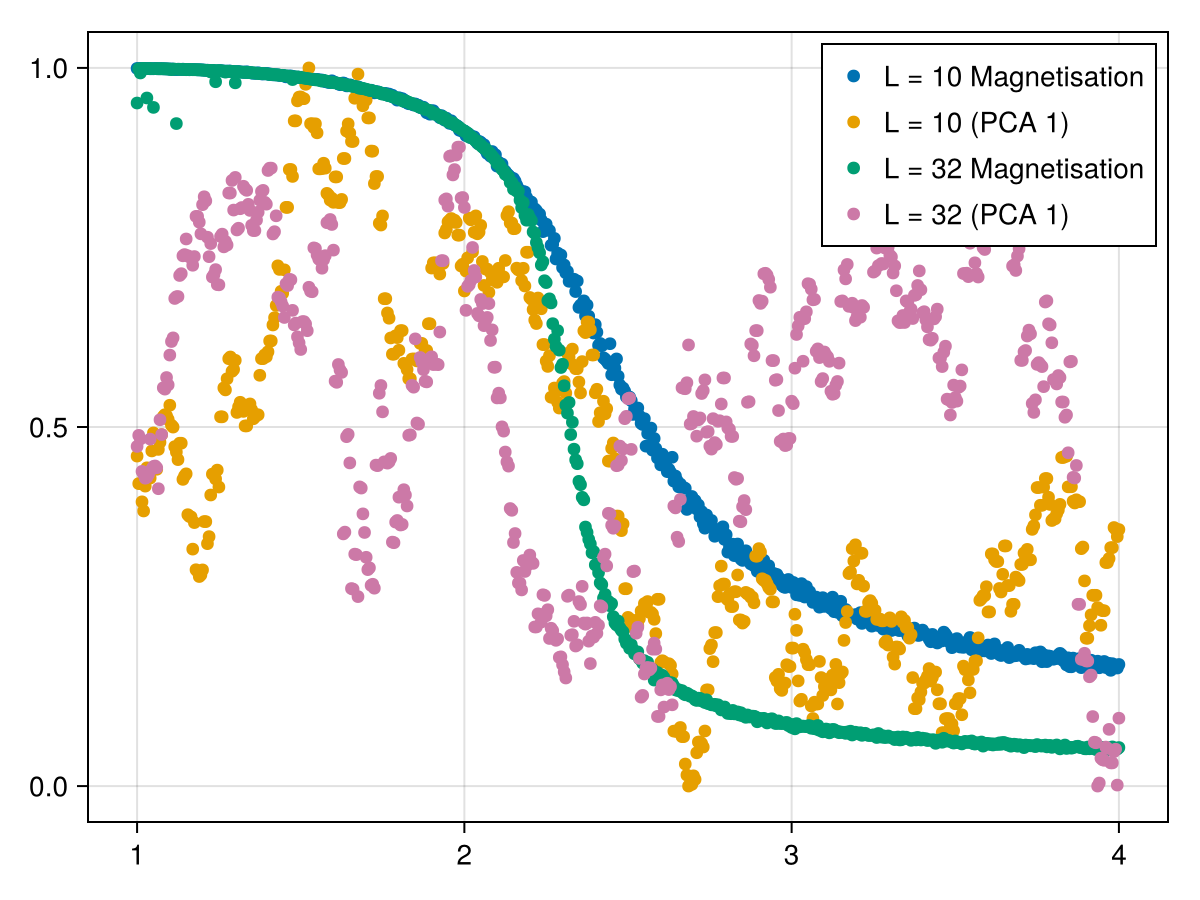

In [12]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1])
for (i, L) in collect(enumerate(grid_sizes))
    cm.plot!(ax, temps, mags[i], label="L = $L Magnetisation")
    cm.plot!(ax, temps, normalize(a_mean[i][1]), label="L = $L (PCA 1)")
end
cm.axislegend(ax, position=:rt)
fig

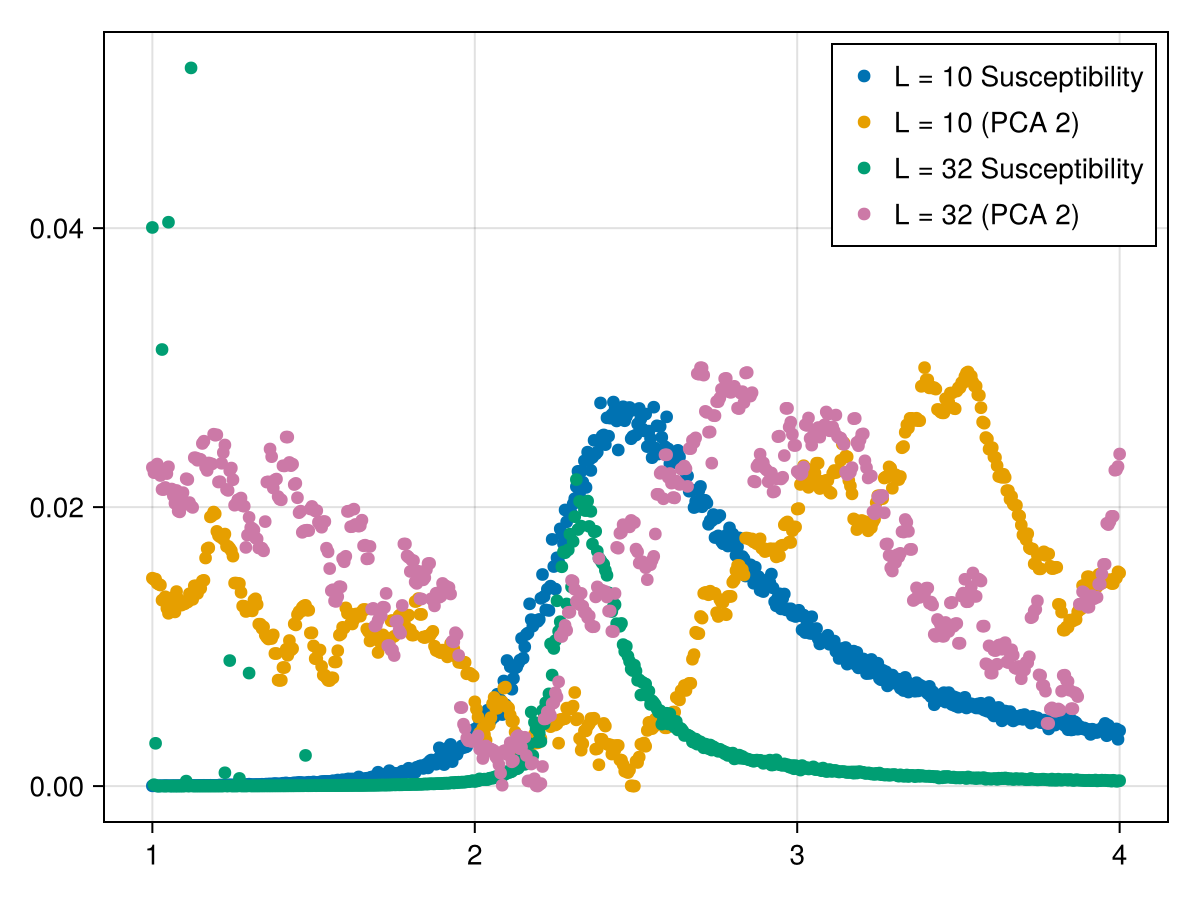

In [13]:
fig = cm.Figure()
ax = cm.Axis(fig[1, 1])
for (i, L) in collect(enumerate(grid_sizes))
    cm.plot!(ax, temps, sus[i], label="L = $L Susceptibility")
    cm.plot!(ax, temps,normalize(a_mean[i][2]).*0.03, label="L = $L (PCA 2)")
end
cm.axislegend(ax, position=:rt)
fig